In [ ]:
!pip install pandas numpy matplotlib scikit-learn keras imbalanced-learn mpld3

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedBaggingClassifier


df = pd.read_csv(r"/content/data.csv", header=0)
df.drop(['id', 'Unnamed: 32'], axis=1, inplace=True)
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})


X = df.drop(columns=['diagnosis'])
y = df['diagnosis']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=41, shuffle=True)


sm = SMOTE(sampling_strategy=0.7, random_state=42, k_neighbors=2)
X_res, y_res = sm.fit_resample(X_train, y_train)



def bootstrap_sampling(X, y, n_samples=5):
    bootstrap_data = []
    n = len(X)

    for _ in range(n_samples):
        indices = np.random.choice(n, size=n, replace=True)
        X_boot = X[indices]
        y_boot = y.iloc[indices]
        bootstrap_data.append((X_boot, y_boot))

    return bootstrap_data


bootstrap_datasets = bootstrap_sampling(X_res, y_res, n_samples=5)


param_grid_rf = {
    'n_estimators': [10, 20],
    'max_depth': [3, 5],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 5],
    'max_features': [0.5, 0.7],
}

param_grid_et = {
    'n_estimators': [10, 20],
    'max_depth': [3, 5],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 5],
    'max_features': [0.5, 0.7],
}

param_grid_ada = {
    'n_estimators': [10, 20],
    'learning_rate': [0.05, 0.1],
    'estimator': [DecisionTreeClassifier(max_depth=2), DecisionTreeClassifier(max_depth=3)]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, scoring='accuracy', cv=5, n_jobs=-1)
grid_search_rf.fit(X_res, y_res)

grid_search_et = GridSearchCV(ExtraTreesClassifier(random_state=42), param_grid_et, scoring='accuracy', cv=5, n_jobs=-1)
grid_search_et.fit(X_res, y_res)

grid_search_ada = GridSearchCV(AdaBoostClassifier(random_state=42), param_grid_ada, scoring='accuracy', cv=5, n_jobs=-1)
grid_search_ada.fit(X_res, y_res)

best_rf = grid_search_rf.best_estimator_
best_et = grid_search_et.best_estimator_
best_ada = grid_search_ada.best_estimator_

print("Best Parameters for Random Forest:", grid_search_rf.best_params_)
print("Best Parameters for Extra Trees:", grid_search_et.best_params_)
print("Best Parameters for AdaBoost:", grid_search_ada.best_params_)


adaboost_models = []
for i, (X_boot, y_boot) in enumerate(bootstrap_datasets):
    model = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=3),
        n_estimators=20, learning_rate=0.1, random_state=42
    )
    model.fit(X_boot, y_boot)
    adaboost_models.append(model)
    print(f"Adaboost Model {i+1} trained on bootstrap sample.")


def majority_voting(models, adaboost_models, X_test):
    model_predictions = np.array([model.predict(X_test) for model in models.values()])
    adaboost_predictions = np.array([model.predict(X_test) for model in adaboost_models])
    all_predictions = np.vstack((model_predictions, adaboost_predictions))
    final_predictions = mode(all_predictions, axis=0).mode.flatten()
    print("Final Predictions Shape:", final_predictions.shape)
    return final_predictions


models = {
    "Random Forest": best_rf,
    "Extra Trees": best_et,
    "Naive Bayes": GaussianNB().fit(X_res, y_res),
    "Balanced Bagging": BalancedBaggingClassifier(
        estimator=DecisionTreeClassifier(max_depth=3),
        n_estimators=10, max_samples=0.7, max_features=0.7,
        sampling_strategy='auto', replacement=False, random_state=42
    ).fit(X_res, y_res)
}

final_preds = majority_voting(models, adaboost_models, X_test)


y_test = np.array(y_test).flatten()
final_accuracy = accuracy_score(y_test, final_preds)
final_precision = precision_score(y_test, final_preds)
final_f1 = f1_score(y_test, final_preds)
final_auc = roc_auc_score(y_test, final_preds)
final_cm = confusion_matrix(y_test, final_preds)

print("**Final Optimized Ensemble Model Performance:**")
print("Accuracy:", final_accuracy)
print("Precision:", final_precision)
print("F1 Score:", final_f1)
print("AUC Score:", final_auc)
print("Confusion Matrix:\n", final_cm)


Best Parameters for Random Forest: {'max_depth': 5, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 20}
Best Parameters for Extra Trees: {'max_depth': 5, 'max_features': 0.7, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 20}
Best Parameters for AdaBoost: {'estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.1, 'n_estimators': 20}
Adaboost Model 1 trained on bootstrap sample.
Adaboost Model 2 trained on bootstrap sample.
Adaboost Model 3 trained on bootstrap sample.
Adaboost Model 4 trained on bootstrap sample.
Adaboost Model 5 trained on bootstrap sample.
Final Predictions Shape: (114,)
**Final Optimized Ensemble Model Performance:**
Accuracy: 0.9824561403508771
Precision: 0.9523809523809523
F1 Score: 0.975609756097561
AUC Score: 0.9864864864864865
Confusion Matrix:
 [[72  2]
 [ 0 40]]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=41, shuffle=True)

sm = SMOTE(sampling_strategy=0.7, random_state=42, k_neighbors=2)
X_res, y_res = sm.fit_resample(X_train, y_train)

#Boostrap Sampling
def bootstrap_sampling(X, y, n_samples=5):
    bootstrap_data = []
    n = len(X)

    for _ in range(n_samples):
        indices = np.random.choice(n, size=n, replace=True)
        X_boot = X[indices]
        y_boot = y.iloc[indices]
        bootstrap_data.append((X_boot, y_boot))

    return bootstrap_data


bootstrap_datasets = bootstrap_sampling(X_res, y_res, n_samples=5)

adaboost_models = []
for i, (X_boot, y_boot) in enumerate(bootstrap_datasets):
    model = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=3),
        n_estimators=50, learning_rate=0.2, random_state=42
    )
    model.fit(X_boot, y_boot)
    adaboost_models.append(model)
    print(f"Adaboost Model {i+1} trained on bootstrap sample.")


def majority_voting(models, X_test):
    predictions = np.array([model.predict(X_test) for model in models])
    final_predictions = mode(predictions, axis=0).mode


    final_predictions = np.array(final_predictions).flatten()

    print("Final Predictions Shape:", final_predictions.shape)

    return final_predictions


final_preds = majority_voting(adaboost_models, X_test)


print("Shape of final_preds:", final_preds.shape)
print("Shape of y_test:", y_test.shape)


y_test = np.array(y_test).flatten()

accuracy = accuracy_score(y_test, final_preds)
auc = roc_auc_score(y_test, final_preds)
cm = confusion_matrix(y_test, final_preds)
final_precision = precision_score(y_test, final_preds)
final_f1 = f1_score(y_test, final_preds)


print("Final Bagoost Performance (Bootstrap + Adaboost):**")
print("Accuracy:", accuracy)
print("AUC Score:", auc)
print("Confusion Matrix:\n", cm)
print("Precision:", final_precision)
print("F1 Score:", final_f1)


Adaboost Model 1 trained on bootstrap sample.
Adaboost Model 2 trained on bootstrap sample.
Adaboost Model 3 trained on bootstrap sample.
Adaboost Model 4 trained on bootstrap sample.
Adaboost Model 5 trained on bootstrap sample.
Final Predictions Shape: (114,)
Shape of final_preds: (114,)
Shape of y_test: (114,)
Final Bagoost Performance (Bootstrap + Adaboost):**
Accuracy: 0.9912280701754386
AUC Score: 0.9932432432432433
Confusion Matrix:
 [[73  1]
 [ 0 40]]
Precision: 0.975609756097561
F1 Score: 0.9876543209876543


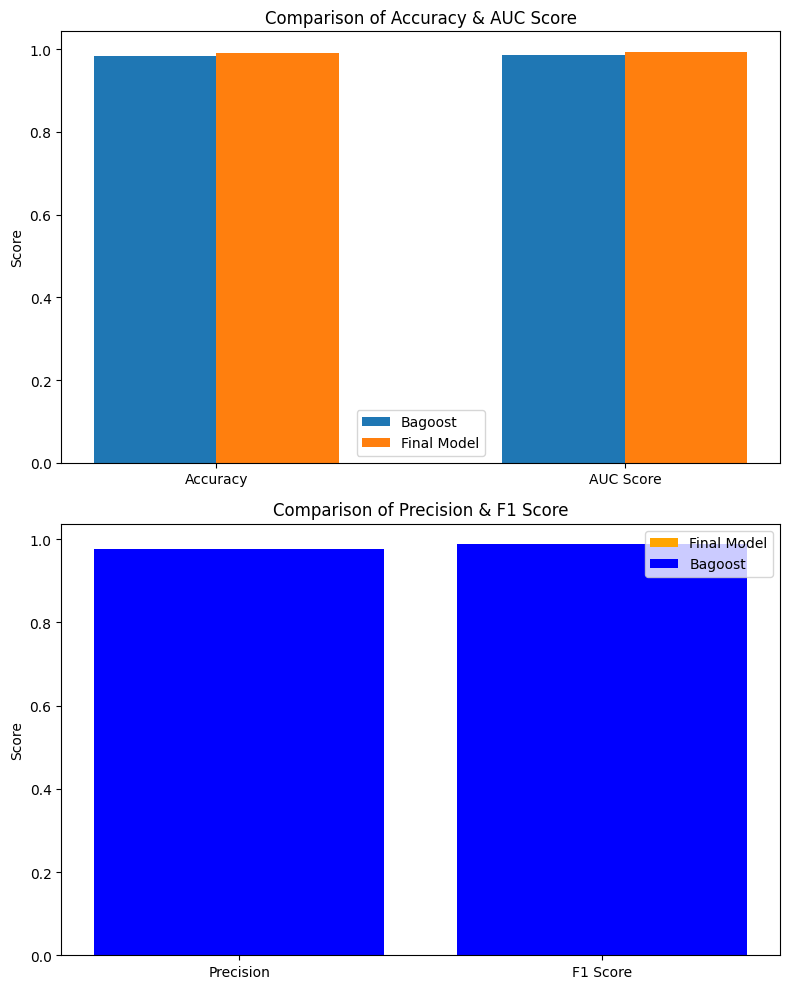

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

metrics_bagoost = {
    "Accuracy": 0.9824561403508771,
    "AUC Score": 0.9864864864864865,
    "Precision": 0.975609756097561,
    "F1 Score": 0.9876543209876543,
}


metrics_final = {
    "Accuracy": 0.9912280701754386,
    "AUC Score": 0.9932432432432433,
    "Precision": 0.975609756097561,
    "F1 Score": 0.9876543209876543,
}


common_metrics = ["Accuracy", "AUC Score"]
values_bagoost = [metrics_bagoost[m] for m in common_metrics]
values_final = [metrics_final[m] for m in common_metrics]


fig, axes = plt.subplots(2, 1, figsize=(8, 10))


x = np.arange(len(common_metrics))
width = 0.3

axes[0].bar(x - width/2, values_bagoost, width, label="Bagoost")
axes[0].bar(x + width/2, values_final, width, label="Final Model")
axes[0].set_xticks(x)
axes[0].set_xticklabels(common_metrics)
axes[0].set_ylabel("Score")
axes[0].set_title("Comparison of Accuracy & AUC Score")
axes[0].legend()


additional_metrics = ["Precision", "F1 Score"]
values_final_only = [metrics_final[m] for m in additional_metrics]

axes[1].bar(additional_metrics, values_final_only, color="orange", label="Final Model")
axes[1].bar(additional_metrics, values_final_only, color="blue", label="Bagoost")
axes[1].set_ylabel("Score")
axes[1].set_title("Comparison of Precision & F1 Score")
axes[1].legend()

plt.tight_layout()
plt.show()